In [25]:
# Qiskit and maths
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Initialize, QFT, TwoLocal
from qiskit_aer.primitives import Sampler

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Finance information
import yfinance as yf
import pandas as pd

# Extras :)
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [23]:
def train_qgan(
    quantum_gen_fn, generator_params, discriminator, dataloader,
    num_epochs=100, disc_lr=5e-5, g_lr=2e-4, latent_dim=8, device='cpu',
    generator_update_fn=None, n_qubits=None, k_layers=None, bounds=None, mu=None, sigma=None
):

    gen_losses = []
    disc_losses = []
    kl_divs = []
    entropies = []
    mode_coverages = []

    discriminator.to(device)
    epsilon = 1e-8
    bins = 2 ** n_qubits

    dis_opt = optim.Adam(discriminator.parameters(), lr=disc_lr, amsgrad=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        for real_data_batch in tqdm(dataloader, desc="Training step"):
            real_data = real_data_batch[0].to(device)
            batch_size = real_data.size(0)

            # === Train Discriminator ===
            dis_opt.zero_grad()

            # Real data
            real_preds = discriminator(real_data)
            real_labels = torch.full_like(real_preds, 0.9)  # Label smoothing

            # Fake data (from quantum circuit)
            noise = torch.randn(batch_size, latent_dim)
            fake_data = quantum_gen_fn(noise, generator_params).detach().to(device)
            fake_preds = discriminator(fake_data)
            fake_labels = torch.full_like(fake_preds, 0.1)  # Label smoothing

            real_loss = F.binary_cross_entropy(real_preds, real_labels)
            fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            dis_opt.step()

            # === Train Generator ===
            noise = torch.randn(batch_size, latent_dim)
            fake_data = quantum_gen_fn(noise, generator_params).to(device)
            fake_preds = discriminator(fake_data)
            gen_targets = torch.full_like(fake_preds, 0.9)
            gen_loss = F.binary_cross_entropy(fake_preds, gen_targets)

            generator_update_fn(
                theta=generator_params, noise_batch=noise, discriminator=discriminator
            )

        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())

        # === KL Divergence, Entropy, Mode Coverage ===
        noise = torch.randn(1000, latent_dim)
        fake_samples = quantum_gen_fn(noise, generator_params).detach().cpu()
        fake_flat = fake_samples.mean(dim=0)
        real_flat = real_data[:len(fake_samples)].mean(dim=0).cpu()

        fake_prob = fake_flat / fake_flat.sum() + epsilon
        real_prob = real_flat / real_flat.sum() + epsilon

        kl = F.kl_div(fake_prob.log(), real_prob, reduction='batchmean')
        entropy = -torch.sum(fake_prob * fake_prob.log()).item()
        mode_coverage = (fake_prob > 1e-3).sum().item()

        kl_divs.append(kl.item())
        entropies.append(entropy)
        mode_coverages.append(mode_coverage)

        # === Combined LIVE PLOTS ===
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))

        axs[0].plot(gen_losses, label="Generator")
        axs[0].plot(disc_losses, label="Discriminator")
        axs[0].set_title("Losses")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(kl_divs, label="KL(G || R)", color='purple')
        axs[1].set_title("KL Divergence")
        axs[1].legend()
        axs[1].grid(True)

        real_indices = np.random.choice(np.arange(bins), p=real_prob.numpy(), size=1000)
        fake_indices = np.random.choice(np.arange(bins), p=fake_prob.numpy(), size=1000)
        axs[2].hist(real_indices, bins=bins, alpha=0.5, label="Real", density=True)
        axs[2].hist(fake_indices, bins=bins, alpha=0.5, label="Generated", density=True)
        axs[2].set_title("Distribution Comparison")
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

        print(f"Epoch [{epoch+1}/{num_epochs}]  D_loss: {disc_loss.item():.4f}  G_loss: {gen_loss.item():.4f}  KL: {kl.item():.4f}  Entropy: {entropy:.4f}  Coverage: {mode_coverage}/{bins}")


In [18]:
def custom_normal_encoding(n, mu=0, sigma=1, bounds=(-np.pi, np.pi)):
    dim = 2 ** n
    x = np.linspace(bounds[0], bounds[1], dim)

    # Evaluate normal distribution (PDF)
    probs = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    probs /= np.sum(probs)  # Normalize

    # Convert to amplitudes
    amps = np.sqrt(probs)

    # Create quantum circuit
    qc = QuantumCircuit(n)
    init = Initialize(amps)
    qc.append(init, range(n))

    return qc

In [ ]:
# Cached circuit
def build_parameterized_circuit(n, k):
    theta_params = ParameterVector("θ", length=(n * k * 2))  # Adjust size as needed
    noise_params = ParameterVector("ζ", length=n)
    
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.ry(noise_params[i], i)

    ansatz = TwoLocal(n, 'ry', 'cz', reps=k, entanglement='circular', parameter_prefix="θ")
    qc.compose(ansatz, inplace=True)
    qc.measure_all()

    return qc, noise_params, ansatz.parameters

# Define once
QC_TEMPLATE, NOISE_PARAMS, ANSATZ_PARAMS = build_parameterized_circuit(n=4, k=2)  # Replace with your actual n, k


def quantum_gen_fn(noise_batch, theta, n, k, bounds, mu, sigma):
    batch_size = noise_batch.shape[0]
    flat_theta = theta.detach().cpu().numpy()
    
    # Interpolate noise → bounds range
    noise_np = noise_batch.detach().cpu().numpy()
    lower, upper = bounds
    noise_angles = (noise_np + 1) / 2 * (upper - lower) + lower

    # Create parameter bindings for each circuit in the batch
    parameter_values = []
    for i in range(batch_size):
        noise_vec = noise_angles[i]
        param_bindings = list(noise_vec) + list(flat_theta)
        parameter_values.append(param_bindings)

    # Run batched circuits
    results = SAMPLER.run([QC_TEMPLATE] * batch_size, parameter_values=parameter_values).result()

    # Convert quasi-dists to tensor
    batch_outputs = []
    dim = 2 ** n
    for dist in results.quasi_dists:
        hist = np.zeros(dim)
        for bitstring, prob in dist.items():
            idx = int(bitstring, 2) if isinstance(bitstring, str) else int(bitstring)
            hist[idx] = prob
        batch_outputs.append(hist)

    return torch.tensor(batch_outputs, dtype=torch.float32)

In [ ]:
def parameter_shift_update(theta, noise_batch, discriminator, lr, n_qubits, k_layers, bounds, mu, sigma, quantum_gen_fn):
    num_params = theta.shape[0]
    shift = np.pi / 2
    grad = torch.zeros_like(theta)
    batch_size = noise_batch.size(0)

    ones = torch.ones((batch_size, 1))

    with torch.no_grad():
        for i in range(num_params):
            theta_plus = theta.clone()
            theta_plus[i] += shift
            theta_minus = theta.clone()
            theta_minus[i] -= shift

            g_plus = quantum_gen_fn(noise_batch, theta_plus, n_qubits, k_layers, bounds, mu, sigma)
            g_minus = quantum_gen_fn(noise_batch, theta_minus, n_qubits, k_layers, bounds, mu, sigma)

            D_plus = discriminator(g_plus)
            D_minus = discriminator(g_minus)

            loss = torch.nn.BCELoss()
            loss_plus = loss(D_plus, ones)
            loss_minus = loss(D_minus, ones)

            grad[i] = (loss_plus - loss_minus) / 2
            grad[i] = grad[i].clamp(-1.0, 1.0)  # Gradient clipping

        theta -= lr * grad

# Load the data

In [21]:
# Create QFT states
n_qubits = 6

# Initialize basis state |x⟩ = |5⟩ for example (can be any 0–7)
x = 5
qc = QuantumCircuit(n_qubits)
qc.initialize([0]*x + [1] + [0]*(2**n_qubits - x - 1), range(n_qubits))

# Apply QFT
qft = QFT(num_qubits=n_qubits, do_swaps=False).decompose()
qc.append(qft, range(n_qubits))

# Simulate
sv = Statevector.from_instruction(qc)

# Measurement probabilities
probs = sv.probabilities_dict()

# Turn into vector over 2^n bins
target_distribution = np.zeros(2**n_qubits)
for bitstring, prob in probs.items():
    idx = int(bitstring, 2)
    target_distribution[idx] = prob

# Convert to torch tensor
real_data = torch.tensor(target_distribution, dtype=torch.float32)

# Train the Data

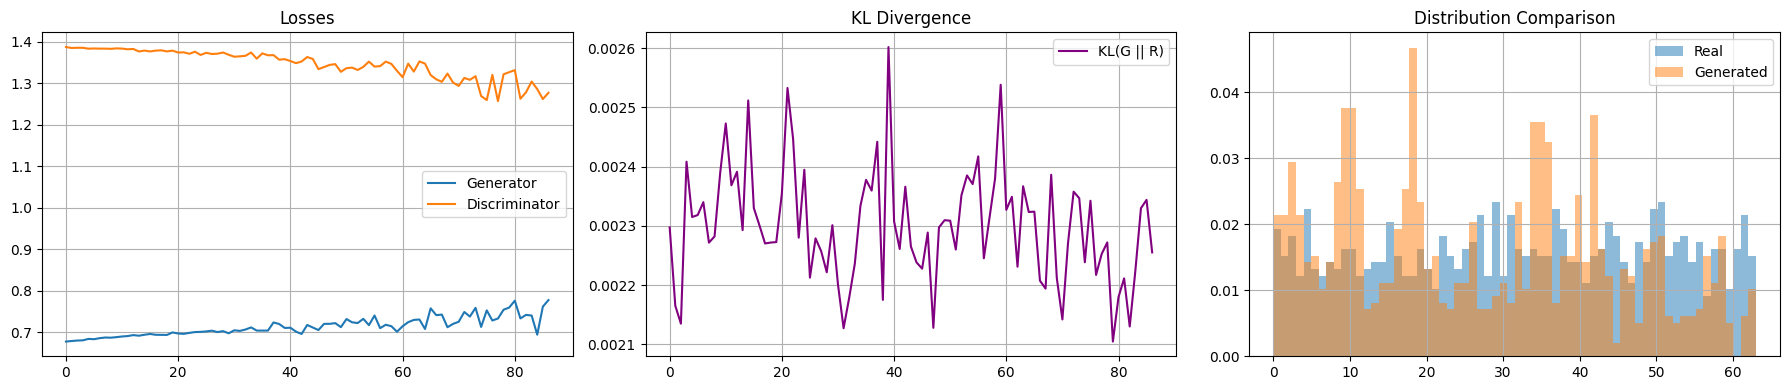

Epoch [87/100]  D_loss: 1.2766  G_loss: 0.7776  KL: 0.0023  Entropy: 4.0177  Coverage: 64/64
Epoch 88


Training step:  44%|████████████▎               | 14/32 [02:35<03:19, 11.08s/it]

In [ ]:
# === Setup Parameters ===
mu = 0.5
sigma = 1
bounds = [-1.5, 1.5]
n = 6
k = 3
latent_dim = n

# Use a dummy ansatz to get the correct number of parameters
dummy_ansatz = TwoLocal(n, 'ry', 'cz', reps=k, entanglement='circular')
num_ansatz_params = len(dummy_ansatz.parameters)

theta = nn.Parameter(torch.rand(num_ansatz_params, dtype=torch.float32, requires_grad=True))

# === Prepare Real Data ===
num_samples = 1000
samples = torch.tensor([target_distribution] * num_samples, dtype=torch.float32)
train_load = DataLoader(TensorDataset(samples), batch_size=32, shuffle=True)

# === Discriminator Model ===
model = nn.Sequential(
    nn.Linear(2**n, 20),
    nn.LeakyReLU(0.01),
    nn.Linear(20, 1),
    nn.Sigmoid()
)

# === Generator Update Function Wrapper ===
gen_update_fn = partial(
    parameter_shift_update,
    lr=2e-4, n_qubits=n, k_layers=k, bounds=bounds, mu=mu, sigma=sigma
)

# === Train QGAN ===
train_qgan(
    quantum_gen_fn=lambda noise, theta: quantum_gen_fn(
        noise, theta, n=n, k=k, bounds=bounds, mu=mu, sigma=sigma
    ),
    generator_params=theta,
    discriminator=model,
    dataloader=train_load,
    g_lr=2e-4,
    generator_update_fn=gen_update_fn,
    n_qubits=n,
    k_layers=k,
    bounds=bounds,
    mu=mu,
    sigma=sigma
)